# Statistical Methods in AI (CSE/ECE 471) - Spring-2020
#  Assignment-1 / **Q1** / Topic: k Nearest Neighbours
# Submitted By: VENUGOPAL REDDY MEKA
# Roll No: 2019900065

In [1]:
# Load the required imports
import matplotlib.pyplot as plt
import seaborn as sns

# use matplotlib inline for Jupyter notebook
%matplotlib inline

## Load the class KNNClassifier

In [2]:
"""
Statistical Methods in AI (CSE/ECE 471)
Spring-2020
Assignment-1
Q1
Topic: K-Nearest Neighbours
Submitted By: VENUGOPAL REDDY MEKA
Roll No: 2019900065
"""

import pandas as pd
import numpy as np
import math
import logging.config

from collections import Counter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Configuration for logging
logging_config = {
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {
        'standard': {
            'format': '%(asctime)s - %(levelname)s - %(name)s - %(message)s',
            'datefmt': "%Y-%m-%d %H:%M:%S"
        }
    },
    'handlers': {
        'console': {
            'level': 'DEBUG',
            'formatter': 'standard',
            'class': 'logging.StreamHandler',
            'stream': 'ext://sys.stdout',
        }
    },
    'loggers': {
        '': {
            'handlers': ['console'],
            'level': 'INFO'
        },
    }
}
logging.config.dictConfig(logging_config)


class KNNClassifier:
    """
    KNNClassifier to predict digits from hand written image vectors using
    K Nearest Neighbours algorithm
    """

    def __init__(self, k=3):
        """
        Init
        """
        self.logger = logging.getLogger(__name__)
        if k > 0:
            self.k = int(k)
        else:
            self.logger.warning("Number of neighbours k to be considered for kNN should be > 0. \
                                 Using the default value - 3")
            self.k = 3

        # Used for caching the train data
        self.df = None
        self.X = None
        self.y = None

    def train(self, train_csv):
        """
        Creates train-validation data split and computes the optimal K value
        :param train_csv:
        :return: None
        """
        try:
            if not train_csv:
                raise ValueError("Input train data csv cannot be None")

            # load the csv file
            self.logger.info("Loading the train data into dataframe")
            self.df = pd.read_csv(train_csv, header=None)

            # Extract features and target data in a seperate dataframes
            df_features = self.df.drop(columns=[0], axis=1)
            df_target = self.df[[0]]

            # Scale the features using min max method
            df_features = self.perform_scaling(df_features)

            # Transform to numpy arrays
            self.X = np.array(df_features)
            self.y = np.array(df_target[df_target.columns[0]])

        except Exception as err:
            self.logger.error("Error occurred while loading the training data ", str(err))

    def predict(self, test_csv):
        """
        Predicts the hand written digits from the 784 dimensional vector's of the test data
        :param test_csv:
        :return: list of predicted digits
        :rtype: List
        """
        try:
            if not test_csv:
                raise ValueError("Input test data csv cannot be None")

            # load the csv file
            self.logger.info("Loading the test data into dataframe")
            df = pd.read_csv(test_csv, header=None)

            # Scale the features using min max method
            df_features = self.perform_scaling(df)

            # Transform to numpy arrays
            X_test = np.array(df_features)

            return self.predict_with_k(X_test=X_test)

        except Exception as err:
            self.logger.error("Error occurred while updating the training data ", str(err))

    def perform_scaling(self, df):
        """
        Performs scaling using the max value of the column
        Ignore scaling, when the max value is 0 to avoid div by zero
        :param df:
        :return:
        """
        self.logger.info("Scaling the data")

        df_scaled = df.copy()
        for feature_name in df.columns:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            # No scaling when min and max values are 0's
            if min_value == 0 and max_value == 0:
                df_scaled[feature_name] = df[feature_name]
            else:
                df_scaled[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)

        self.logger.info("Completed Scaling the data")

        return df_scaled

    def predict_with_k(self, X_test, k=None, metric='euclidean'):
        """
        Predict using k nearest neighbours and given metric
        :param X_test:
        :param k:
        :param metric:
        :return:
        """
        try:
            if not k:
                k = self.k

            # Capture all the distances
            distances_array = self.get_distances(self.X, X_test, metric)

            y_pred = list()
            y_train = self.y
            for idx in range(0, X_test.shape[0]):
                distances = distances_array[idx][0:k]
                nearest_neighbours = list()
                for index in distances:
                    nearest_neighbours.append(y_train[index])

                predicted_label = Counter(nearest_neighbours).most_common(1)
                y_pred.append(predicted_label[0][0])

            return y_pred

        except Exception as err:
            self.logger.error("Error while doing predict_with_k method.", str(err))
            raise

    def get_distances(self, X_train, X_validate, metric):
        """
        Returns the list of distances between each validate and train vectors
        :param X_train:
        :param X_validate:
        :param metric:
        :return:
        """
        self.logger.info(f"Computing {metric} distances")

        distances_array = list()
        for point in X_validate:
            if metric == 'euclidean':
                euc_distance = self.get_euclidean_distance(X=X_train, point=point)
                distances = np.argsort(euc_distance)
            elif metric == 'manhattan':
                manh_distance = self.get_manhattan_distance(X=X_train, point=point)
                distances = np.argsort(manh_distance)
            else:
                raise ValueError("Undefined Metric")
            distances_array.append(distances)

        return distances_array

    def train_validation_split(self, df, validation_size=0.25):
        """
        Split the data into train, validation using the validation_size
        :param df
        :param validation_size:
        :return: X_train, y_train, X_validate, y_validate
        """
        self.logger.info(f"Splitting the train data to train, validation sets with validation_size: {validation_size}")
        # Extract features and target data in a seperate dataframes
        df_features = df.drop(columns=[0], axis=1)
        df_target = df[[0]]
        # Scale the features using min max method
        df_features = self.perform_scaling(df_features)

        # Transform to numpy arrays
        X = np.array(df_features)
        y = np.array(df_target[df_target.columns[0]])
        # split and capture train, validation indexes
        indices = np.random.permutation(X.shape[0])
        n_train_indices = int(X.shape[0] * (1.0 - validation_size))
        training_idx, validate_idx = indices[:n_train_indices], indices[n_train_indices:]

        X_train, X_validate = X[training_idx, :], X[validate_idx, :]
        y_train, y_validate = y[training_idx], y[validate_idx]

        return X_train, y_train, X_validate, y_validate

    def predict_with_k_range(self,
                             X_train,
                             y_train,
                             X_validate,
                             y_validate,
                             k_min=1,
                             k_max=20,
                             metric='euclidean'):
        """
        Predict within K range
        """
        try:
            if k_min <= 0 or \
                    k_max <= 0 or \
                    k_min > k_max:
                raise ValueError(f"Invalid value for k_min: {k_min}, k_max: {k_max}")

            # Capture all the distances
            distances_array = self.get_distances(X_train, X_validate, metric)

            results = list()
            max_accuracy = -math.inf
            k_best = None
            for k in range(k_min, k_max + 1):
                predicted_digits, accuracy = self.get_results(y_train, y_validate, distances_array, k)
                if accuracy > max_accuracy:
                    max_accuracy = accuracy
                    k_best = k

                results.append((predicted_digits, accuracy))

            return y_validate, results, k_best

        except Exception as err:
            self.logger.error(f"Error while predicting within k range {k_min} and {k_max}.", str(err))
            raise

    def get_results(self, y_train, y_validate, distances_array, k):
        """

        :param y_train:
        :param y_validate:
        :param distances_array:
        :param k:
        :return:
        """
        self.logger.info(f"Processing for k value : {k}")
        predicted_digits = list()
        sample_size = y_validate.shape[0]
        for idx in range(0, sample_size):
            distances = distances_array[idx][0:k]
            nearest_neighbours = list()
            for index in distances:
                nearest_neighbours.append(y_train[index])

            predicted_digit = Counter(nearest_neighbours).most_common(1)
            predicted_digits.append(predicted_digit[0][0])

        accuracy = self.get_accuracy(y_validate, np.array(predicted_digits))
        self.logger.info(f"Accuracy for k value : {k} - {accuracy}")

        return predicted_digits, accuracy

    @staticmethod
    def get_euclidean_distance(X, point):
        return np.sqrt(np.sum((X - point) ** 2, axis=1))

    @staticmethod
    def get_manhattan_distance(X, point):
        return np.sum(np.abs(X - point), axis=1)

    @staticmethod
    def get_accuracy(actual, predicted):
        """
        Returns accuracy in percentage from the actual and predicted numpy arrays
        :param actual:
        :param predicted:
        :return:
        """
        return (actual == predicted).mean() * 100

    def confusion_matrix(self, y_actual, y_pred, labels=None):
        """

        :param y_actual:
        :param y_pred:
        :param labels:
        :return:
        """
        cm = confusion_matrix(y_actual, y_pred, labels)
        self.logger.info(f'Confusion matrix: \n {cm}')
        return cm

    def multilabel_confusion_matrix(self, y_actual, y_pred, labels=None):
        """

        :param y_actual:
        :param y_pred:
        :param labels:
        :return:
        """
        mcm = multilabel_confusion_matrix(y_true=y_actual, y_pred=y_pred, labels=labels)
        self.logger.info(f'Multilabel confusion matrix: \n {mcm}')
        return mcm

    def classification_report(self, y_actual, y_pred, labels=None):
        """

        :param y_actual:
        :param y_pred:
        :param labels:
        :return:
        """
        cl_report = classification_report(y_true=y_actual, y_pred=y_pred, labels=labels, output_dict=True)
        df_report = pd.DataFrame(cl_report).transpose()
        self.logger.info(f'Classification Report: \n {df_report}')
        f1_scores = list()
        for label in labels:
            f1_scores.append(cl_report[str(label)]["f1-score"])

        f1_score_mean = cl_report["macro avg"]["f1-score"]
        f1_score_stddev = np.array(f1_scores).std(axis=0)
        f1_score_median = self.get_median(f1_scores)
        f1_score_abs_dev = self.get_absolute_deviation(f1_scores, f1_score_median)

        self.logger.info(f"Mean F1-Score ± Std Deviation: {f1_score_mean} ± {f1_score_stddev}")
        self.logger.info(f"Median F1-Score ±  Median absolute deviation: {f1_score_median} ± {f1_score_abs_dev}")

        return cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev

    @staticmethod
    def get_median(data):
        """

        :param data:
        :return:
        """
        n = len(data)
        data.sort()

        if n % 2 == 0:
            median1 = data[n // 2]
            median2 = data[n // 2 - 1]
            median = (median1 + median2) / 2
        else:
            median = data[n // 2]

        return median

    @staticmethod
    def get_absolute_deviation(data, value):
        """

        :param data:
        :param value:
        :return:
        """
        sum_val = 0
        # Absolute deviation calculation
        for i in range(len(data)):
            av = np.absolute(data[i] - value)
            sum_val = sum_val + av

        return sum_val / len(data)

    def predict_with_k_range_sklearn(self,
                                     df,
                                     k_min=1,
                                     k_max=20,
                                     metric='euclidean',
                                     validation_size=0.25):
        """
        Predict with sklearn classifier
        """
        try:
            if k_min <= 0 or \
                    k_max <= 0 or \
                    k_min > k_max:
                raise ValueError(f"Invalid value for k_min: {k_min}, k_max: {k_max}")

            df_features = df.drop(columns=[0], axis=1)
            df_target = df[[0]]
            scaler = MaxAbsScaler()
            scaler.fit(df_features)
            df_features = pd.DataFrame(scaler.transform(df_features))
            X = df_features
            y = df_target
            X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=validation_size, random_state=101)
            y_actual = np.array(y_validate[0])
            results = list()
            k_best = None
            max_accuracy = -math.inf
            for k in range(k_min, k_max + 1):
                knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
                knn.fit(X_train, np.array(y_train[0]))
                predicted_digits = knn.predict(np.array(X_validate))
                accuracy = accuracy_score(y_actual, predicted_digits) * 100
                if accuracy > max_accuracy:
                    max_accuracy = accuracy
                    k_best = k

                self.logger.info(f"Accuracy for k value : {k} - {accuracy}")
                results.append((predicted_digits, accuracy))

            return y_actual, results, k_best

        except Exception as err:
            self.logger.error("Error while computing k using sklearn knn classifier.", str(err))
            raise


## Experiments

### Load the train data

In [6]:
knn_classifier = KNNClassifier()
df = pd.read_csv('./Datasets/q1/train.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Evaluate with k ranging from 1 to 20

In [7]:
k_min = 1
k_max = 20

Split the train data to train validation sets


In [8]:
X_train, y_train, X_validate, y_validate = knn_classifier.train_validation_split(df=df, validation_size=0.25)
print(X_train.shape)
print(y_train.shape)
print(X_validate.shape)
print(y_validate.shape)

2020-01-31 15:02:51 - INFO - __main__ - Splitting the train data to train, validation sets with validation_size: 0.25
2020-01-31 15:02:51 - INFO - __main__ - Scaling the data
2020-01-31 15:03:48 - INFO - __main__ - Completed Scaling the data
(15000, 784)
(15000,)
(5000, 784)
(5000,)


### Perform evaluation with metric = 'EUCLIDEAN'

In [10]:
y_validate, results, k_best = knn_classifier.predict_with_k_range(X_train=X_train,
                                                                  y_train=y_train,
                                                                  X_validate=X_validate,
                                                                  y_validate=y_validate,
                                                                  k_min=1,
                                                                  k_max=20,
                                                                  metric='euclidean')

2020-01-31 15:09:10 - INFO - __main__ - Computing euclidean distances
2020-01-31 15:24:05 - INFO - __main__ - Processing for k value : 1
2020-01-31 15:24:05 - INFO - __main__ - Accuracy for k value : 1 - 95.64
2020-01-31 15:24:05 - INFO - __main__ - Processing for k value : 2
2020-01-31 15:24:05 - INFO - __main__ - Accuracy for k value : 2 - 95.64
2020-01-31 15:24:05 - INFO - __main__ - Processing for k value : 3
2020-01-31 15:24:05 - INFO - __main__ - Accuracy for k value : 3 - 95.72
2020-01-31 15:24:05 - INFO - __main__ - Processing for k value : 4
2020-01-31 15:24:05 - INFO - __main__ - Accuracy for k value : 4 - 95.88
2020-01-31 15:24:05 - INFO - __main__ - Processing for k value : 5
2020-01-31 15:24:05 - INFO - __main__ - Accuracy for k value : 5 - 95.42
2020-01-31 15:24:05 - INFO - __main__ - Processing for k value : 6
2020-01-31 15:24:05 - INFO - __main__ - Accuracy for k value : 6 - 95.74000000000001
2020-01-31 15:24:05 - INFO - __main__ - Processing for k value : 7
2020-01-31 

In [11]:
accuracy_metrics = list()
f1_scores_mean = list()
for k in range(0, k_max):
    accuracy_metrics.append(results[k][1])
    print("#############################################################################################")
    cm = knn_classifier.confusion_matrix(y_validate, results[k][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    mcm = knn_classifier.multilabel_confusion_matrix(y_validate, results[k][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
    knn_classifier.classification_report(y_validate, results[k][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    f1_scores_mean.append(f1_score_mean)

print("K value with highest accuracy for metric Euclidean: {k_best}")

#############################################################################################
2020-01-31 15:46:56 - INFO - __main__ - Confusion matrix: 
 [[498   0   0   0   0   1   5   0   0   1]
 [  0 535   1   1   1   1   1   1   0   0]
 [  0   1 473   1   1   0   3   3   5   3]
 [  0   2   3 444   0  10   0   3   5   4]
 [  1   3   0   0 452   0   2   2   1  17]
 [  2   1   1  13   2 442   8   0   2   3]
 [  0   2   0   0   0   5 504   0   0   0]
 [  0  11   1   1   0   1   0 507   0   7]
 [  2   6   1   8   3   6   5   6 438   6]
 [  0   0   0   6   8   0   1  16   1 489]]
2020-01-31 15:46:56 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4490    5]
  [   7  498]]

 [[4433   26]
  [   6  535]]

 [[4503    7]
  [  17  473]]

 [[4499   30]
  [  27  444]]

 [[4507   15]
  [  26  452]]

 [[4502   24]
  [  32  442]]

 [[4464   25]
  [   7  504]]

 [[4441   31]
  [  21  507]]

 [[4505   14]
  [  43  438]]

 [[4438   41]
  [  32  489]]]
2020-01-31 15:46:56 - INFO - __main__ - Clas

2020-01-31 15:46:57 - INFO - __main__ - Confusion matrix: 
 [[502   0   0   0   0   1   2   0   0   0]
 [  0 536   1   1   0   0   0   1   0   2]
 [  4   5 463   1   0   1   3   7   4   2]
 [  0   1   5 442   0   8   0   7   4   4]
 [  1   5   0   0 453   0   4   0   1  14]
 [  1   1   0  11   2 446   7   0   1   5]
 [  1   2   0   0   0   2 506   0   0   0]
 [  1  15   0   0   1   1   0 504   0   6]
 [  3   8   2  15   1   8   5   6 425   8]
 [  1   0   0   7   6   1   1  10   1 494]]
2020-01-31 15:46:57 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4483   12]
  [   3  502]]

 [[4422   37]
  [   5  536]]

 [[4502    8]
  [  27  463]]

 [[4494   35]
  [  29  442]]

 [[4512   10]
  [  25  453]]

 [[4504   22]
  [  28  446]]

 [[4467   22]
  [   5  506]]

 [[4441   31]
  [  24  504]]

 [[4508   11]
  [  56  425]]

 [[4438   41]
  [  27  494]]]
2020-01-31 15:46:57 - INFO - __main__ - Classification Report: 
               f1-score  precision    recall    support
0             0.98

2020-01-31 15:46:57 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4480   15]
  [   5  500]]

 [[4415   44]
  [   5  536]]

 [[4501    9]
  [  33  457]]

 [[4494   35]
  [  31  440]]

 [[4514    8]
  [  25  453]]

 [[4498   28]
  [  31  443]]

 [[4464   25]
  [   6  505]]

 [[4445   27]
  [  24  504]]

 [[4509   10]
  [  57  424]]

 [[4438   41]
  [  25  496]]]
2020-01-31 15:46:57 - INFO - __main__ - Classification Report: 
               f1-score  precision    recall    support
0             0.980392   0.970874  0.990099   505.0000
1             0.956289   0.924138  0.990758   541.0000
2             0.956067   0.980687  0.932653   490.0000
3             0.930233   0.926316  0.934183   471.0000
4             0.964856   0.982646  0.947699   478.0000
5             0.937566   0.940552  0.934599   474.0000
6             0.970221   0.952830  0.988258   511.0000
7             0.951841   0.949153  0.954545   528.0000
8             0.926776   0.976959  0.881497   481.0000
9             

2020-01-31 15:46:57 - INFO - __main__ - Classification Report: 
               f1-score  precision    recall    support
0             0.980392   0.970874  0.990099   505.0000
1             0.952128   0.914821  0.992606   541.0000
2             0.950578   0.980477  0.922449   490.0000
3             0.929101   0.926160  0.932059   471.0000
4             0.958730   0.970021  0.947699   478.0000
5             0.942797   0.946809  0.938819   474.0000
6             0.972973   0.960000  0.986301   511.0000
7             0.943503   0.938202  0.948864   528.0000
8             0.923246   0.976798  0.875260   481.0000
9             0.925260   0.912313  0.938580   521.0000
accuracy      0.948200   0.948200  0.948200     0.9482
macro avg     0.947871   0.949648  0.947274  5000.0000
weighted avg  0.948050   0.949082  0.948200  5000.0000
2020-01-31 15:46:57 - INFO - __main__ - Mean F1-Score ± Std Deviation: 0.9478707035188452 ± 0.0182918699678447
2020-01-31 15:46:57 - INFO - __main__ - Median F1-Scor

2020-01-31 15:46:58 - INFO - __main__ - Mean F1-Score ± Std Deviation: 0.9424043387374045 ± 0.020572844150845215
2020-01-31 15:46:58 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 0.9426352090725205 ± 0.016625231543256513
#############################################################################################
2020-01-31 15:46:58 - INFO - __main__ - Confusion matrix: 
 [[497   0   1   1   0   1   5   0   0   0]
 [  0 537   2   0   0   0   0   1   0   1]
 [  6  12 448   3   2   4   3   5   3   4]
 [  1   5   4 436   0   8   0   6   4   7]
 [  1   7   0   0 449   0   4   1   1  15]
 [  2   3   0  14   3 440   6   1   0   5]
 [  1   3   0   0   0   3 503   0   1   0]
 [  0  16   0   0   0   1   0 502   0   9]
 [  4  14   1  16   1   9   4   5 414  13]
 [  2   1   0   9   6   0   2  12   1 488]]
2020-01-31 15:46:58 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4478   17]
  [   8  497]]

 [[4398   61]
  [   4  537]]

 [[4502    8]
  [  42  448]]

 [[4486   43]

#### Accuracy vs K (Metric: Euclidean)

Text(0,0.5,'Accuarcy')

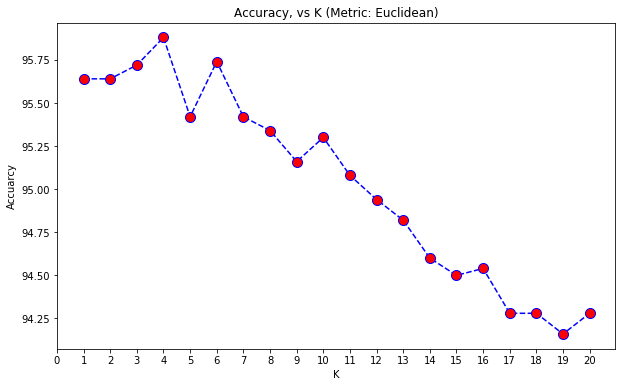

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), accuracy_metrics, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
xint = range(0, k_max+1)
plt.xticks(xint)
plt.title("Accuracy, vs K (Metric: Euclidean)")
plt.xlabel("K")
plt.ylabel("Accuarcy")

#### Mean F1-Score vs K (Metric: Euclidean) 

Text(0,0.5,'Mean F1-Score')

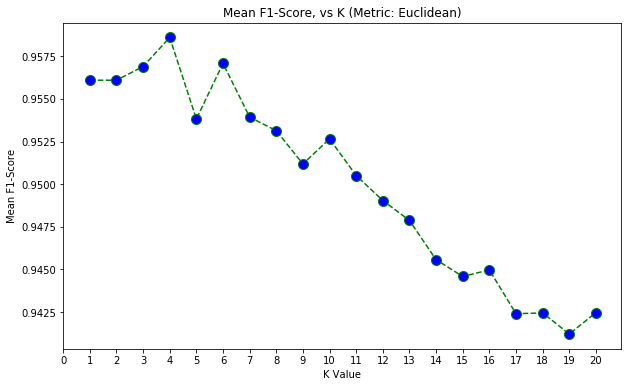

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), f1_scores_mean, color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
xint = range(0, k_max+1)
plt.xticks(xint)
plt.title("Mean F1-Score, vs K (Metric: Euclidean)")
plt.xlabel("K Value")
plt.ylabel("Mean F1-Score")

### Observation for best K Value (Metric: Euclidean)

In [14]:
print(f"K Value: {k_best} with best accuracy (metric: Euclidean): {accuracy_metrics[k_best-1]}")
print("====================================================================")
cm = knn_classifier.confusion_matrix(y_validate, results[k_best-1][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
mcm = knn_classifier.multilabel_confusion_matrix(y_validate, results[k_best-1][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
knn_classifier.classification_report(y_validate, results[k_best-1][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

K Value: 4 with best accuracy (metric: Euclidean): 95.88
2020-01-31 15:47:51 - INFO - __main__ - Confusion matrix: 
 [[501   0   0   1   0   0   3   0   0   0]
 [  0 534   1   1   0   1   1   2   0   1]
 [  3   4 468   2   0   1   3   5   2   2]
 [  0   1   5 445   0   8   0   4   4   4]
 [  1   4   0   0 453   0   4   0   1  15]
 [  1   1   0  11   2 450   6   0   0   3]
 [  0   2   0   0   0   3 506   0   0   0]
 [  0  14   0   0   0   1   0 506   0   7]
 [  2   8   2   8   1   7   5   5 435   8]
 [  0   0   0   7   5   1   1  10   1 496]]
2020-01-31 15:47:51 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4488    7]
  [   4  501]]

 [[4425   34]
  [   7  534]]

 [[4502    8]
  [  22  468]]

 [[4499   30]
  [  26  445]]

 [[4514    8]
  [  25  453]]

 [[4504   22]
  [  24  450]]

 [[4466   23]
  [   5  506]]

 [[4446   26]
  [  22  506]]

 [[4511    8]
  [  46  435]]

 [[4439   40]
  [  25  496]]]
2020-01-31 15:47:51 - INFO - __main__ - Classification Report: 
               f1

### Perform evaluation with metric = 'MANHATTAN'

In [15]:
y_validate, results, k_best = knn_classifier.predict_with_k_range(X_train=X_train,
                                                                  y_train=y_train,
                                                                  X_validate=X_validate,
                                                                  y_validate=y_validate,
                                                                  k_min=1,
                                                                  k_max=20,
                                                                  metric='manhattan')

2020-01-31 22:38:21 - INFO - __main__ - Computing manhattan distances
2020-01-31 22:46:31 - INFO - __main__ - Processing for k value : 1
2020-01-31 22:46:31 - INFO - __main__ - Accuracy for k value : 1 - 94.58
2020-01-31 22:46:31 - INFO - __main__ - Processing for k value : 2
2020-01-31 22:46:31 - INFO - __main__ - Accuracy for k value : 2 - 94.58
2020-01-31 22:46:31 - INFO - __main__ - Processing for k value : 3
2020-01-31 22:46:31 - INFO - __main__ - Accuracy for k value : 3 - 94.84
2020-01-31 22:46:31 - INFO - __main__ - Processing for k value : 4
2020-01-31 22:46:31 - INFO - __main__ - Accuracy for k value : 4 - 95.12
2020-01-31 22:46:31 - INFO - __main__ - Processing for k value : 5
2020-01-31 22:46:32 - INFO - __main__ - Accuracy for k value : 5 - 94.88
2020-01-31 22:46:32 - INFO - __main__ - Processing for k value : 6
2020-01-31 22:46:32 - INFO - __main__ - Accuracy for k value : 6 - 94.76
2020-01-31 22:46:32 - INFO - __main__ - Processing for k value : 7
2020-01-31 22:46:32 - I

In [19]:
accuracy_metrics = list()
f1_scores_mean = list()
for k in range(0, k_max):
    accuracy_metrics.append(results[k][1])
    print("#############################################################################################")
    cm = knn_classifier.confusion_matrix(y_validate, results[k][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    mcm = knn_classifier.multilabel_confusion_matrix(y_validate, results[k][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
    knn_classifier.classification_report(y_validate, results[k][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    f1_scores_mean.append(f1_score_mean)

print(f"K value with highest accuracy for metric Manhattan: {k_best}")

#############################################################################################
2020-01-31 22:48:16 - INFO - __main__ - Confusion matrix: 
 [[499   0   1   0   0   1   4   0   0   0]
 [  0 536   1   1   1   0   1   1   0   0]
 [  1   7 462   1   2   2   3   4   5   3]
 [  0   2   3 442   0  12   0   5   4   3]
 [  1   5   0   0 449   0   3   2   0  18]
 [  2   3   0  18   2 439   8   0   0   2]
 [  2   3   0   0   0   5 501   0   0   0]
 [  0  13   1   1   0   1   0 505   0   7]
 [  3   9   3   9   3  11   6   6 421  10]
 [  1   1   0   6  11   1   1  24   1 475]]
2020-01-31 22:48:16 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4485   10]
  [   6  499]]

 [[4416   43]
  [   5  536]]

 [[4501    9]
  [  28  462]]

 [[4493   36]
  [  29  442]]

 [[4503   19]
  [  29  449]]

 [[4493   33]
  [  35  439]]

 [[4463   26]
  [  10  501]]

 [[4430   42]
  [  23  505]]

 [[4509   10]
  [  60  421]]

 [[4436   43]
  [  46  475]]]
2020-01-31 22:48:16 - INFO - __main__ - Clas

2020-01-31 22:48:16 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4483   12]
  [   4  501]]

 [[4407   52]
  [   4  537]]

 [[4503    7]
  [  35  455]]

 [[4490   39]
  [  30  441]]

 [[4511   11]
  [  27  451]]

 [[4501   25]
  [  33  441]]

 [[4466   23]
  [   6  505]]

 [[4436   36]
  [  23  505]]

 [[4510    9]
  [  64  417]]

 [[4437   42]
  [  30  491]]]
2020-01-31 22:48:16 - INFO - __main__ - Classification Report: 
               f1-score  precision    recall    support
0             0.984283   0.976608  0.992079   505.0000
1             0.950442   0.911715  0.992606   541.0000
2             0.955882   0.984848  0.928571   490.0000
3             0.927445   0.918750  0.936306   471.0000
4             0.959574   0.976190  0.943515   478.0000
5             0.938298   0.946352  0.930380   474.0000
6             0.972089   0.956439  0.988258   511.0000
7             0.944808   0.933457  0.956439   528.0000
8             0.919515   0.978873  0.866944   481.0000
9             

2020-01-31 22:48:16 - INFO - __main__ - Classification Report: 
               f1-score  precision    recall   support
0             0.981318   0.974609  0.988119   505.000
1             0.939633   0.892027  0.992606   541.000
2             0.947257   0.980349  0.916327   490.000
3             0.927966   0.926004  0.929936   471.000
4             0.959488   0.978261  0.941423   478.000
5             0.930818   0.925000  0.936709   474.000
6             0.971154   0.954631  0.988258   511.000
7             0.937442   0.924494  0.950758   528.000
8             0.903010   0.973558  0.841996   481.000
9             0.927481   0.922201  0.932821   521.000
accuracy      0.943000   0.943000  0.943000     0.943
macro avg     0.942557   0.945113  0.941895  5000.000
weighted avg  0.942754   0.944408  0.943000  5000.000
2020-01-31 22:48:16 - INFO - __main__ - Mean F1-Score ± Std Deviation: 0.942556595431674 ± 0.02192168597609559
2020-01-31 22:48:16 - INFO - __main__ - Median F1-Score ±  Median ab

2020-01-31 22:48:16 - INFO - __main__ - Mean F1-Score ± Std Deviation: 0.935205014014094 ± 0.023804348677430944
2020-01-31 22:48:16 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 0.9290414117229759 ± 0.018431505260437363
#############################################################################################
2020-01-31 22:48:16 - INFO - __main__ - Confusion matrix: 
 [[497   0   1   1   0   1   5   0   0   0]
 [  0 537   2   0   0   0   0   2   0   0]
 [  4  17 441   3   2   4   3   9   4   3]
 [  1   6   4 435   0   8   0   9   3   5]
 [  1  10   0   0 445   0   4   2   1  15]
 [  2   6   0  13   3 438   6   1   0   5]
 [  1   6   0   0   0   2 502   0   0   0]
 [  0  18   0   0   1   1   0 500   0   8]
 [  4  20   1  15   1  15   7   5 399  14]
 [  2   1   0   9   6   0   2  16   1 484]]
2020-01-31 22:48:16 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4480   15]
  [   8  497]]

 [[4375   84]
  [   4  537]]

 [[4502    8]
  [  49  441]]

 [[4488   41]


2020-01-31 22:48:16 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 0.929244235104718 ± 0.018080799049298844
#############################################################################################
2020-01-31 22:48:16 - INFO - __main__ - Confusion matrix: 
 [[496   0   1   1   0   1   6   0   0   0]
 [  0 536   2   1   0   0   0   1   0   1]
 [  5  20 439   3   2   3   3   8   4   3]
 [  1   7   5 428   0   9   0  12   3   6]
 [  1  11   0   0 444   0   4   2   0  16]
 [  1   6   0  15   4 435   7   1   0   5]
 [  1   6   0   0   0   3 501   0   0   0]
 [  0  20   0   0   1   1   0 497   0   9]
 [  4  22   2  15   1  13   7   5 400  12]
 [  2   2   0   8   6   0   2  17   1 483]]
2020-01-31 22:48:16 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4480   15]
  [   9  496]]

 [[4365   94]
  [   5  536]]

 [[4500   10]
  [  51  439]]

 [[4486   43]
  [  43  428]]

 [[4508   14]
  [  34  444]]

 [[4496   30]
  [  39  435]]

 [[4460   29]
  [  10  501]]

 [[4426

#### Accuracy vs K (Metric: Manhattan)

Text(0,0.5,'Accuarcy')

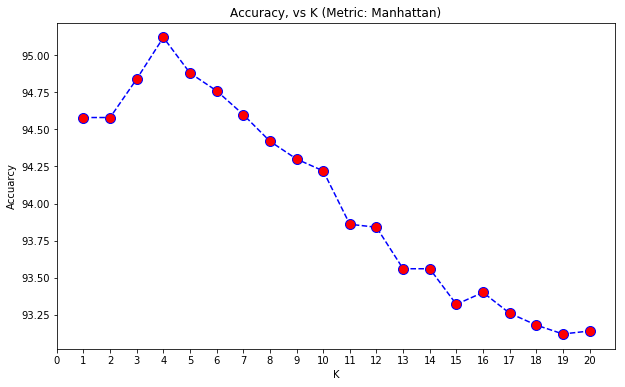

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), accuracy_metrics, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
xint = range(0, k_max+1)
plt.xticks(xint)
plt.title("Accuracy, vs K (Metric: Manhattan)")
plt.xlabel("K")
plt.ylabel("Accuarcy")

#### Mean F1 Score vs K (Manhattan)

Text(0,0.5,'Mean F1-Score')

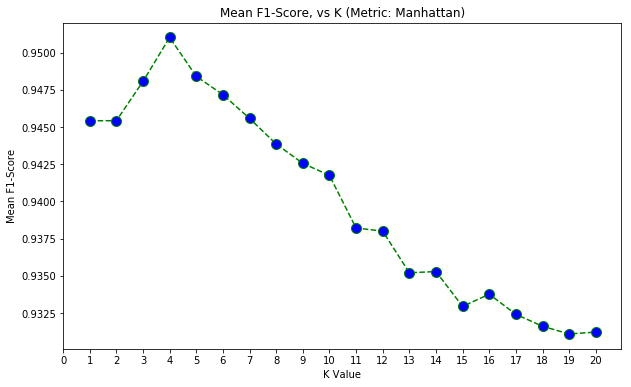

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), f1_scores_mean, color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
xint = range(0, k_max+1)
plt.xticks(xint)
plt.title("Mean F1-Score, vs K (Metric: Manhattan)")
plt.xlabel("K Value")
plt.ylabel("Mean F1-Score")

### Observations for best K value (Metric: Manhattan Distance)

In [20]:
print(f"K Value: {k_best} with best accuracy (metric: Manhattan): {accuracy_metrics[k_best-1]}")
print("====================================================================")
cm = knn_classifier.confusion_matrix(y_validate, results[k_best-1][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
mcm = knn_classifier.multilabel_confusion_matrix(y_validate, results[k_best-1][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
knn_classifier.classification_report(y_validate, results[k_best-1][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

K Value: 4 with best accuracy (metric: Manhattan): 95.12
2020-01-31 22:48:45 - INFO - __main__ - Confusion matrix: 
 [[500   0   1   1   0   0   3   0   0   0]
 [  0 535   1   1   0   0   1   1   0   2]
 [  4   9 458   2   1   2   3   6   2   3]
 [  0   1   3 441   0  11   0   9   2   4]
 [  1   6   0   0 452   0   4   0   0  15]
 [  1   3   0  13   2 445   6   1   0   3]
 [  0   3   0   0   0   3 505   0   0   0]
 [  0  15   0   0   0   1   0 505   0   7]
 [  3  11   2  10   1   8   6   6 424  10]
 [  2   0   0   7   5   0   1  14   1 491]]
2020-01-31 22:48:45 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4484   11]
  [   5  500]]

 [[4411   48]
  [   6  535]]

 [[4503    7]
  [  32  458]]

 [[4495   34]
  [  30  441]]

 [[4513    9]
  [  26  452]]

 [[4501   25]
  [  29  445]]

 [[4465   24]
  [   6  505]]

 [[4435   37]
  [  23  505]]

 [[4514    5]
  [  57  424]]

 [[4435   44]
  [  30  491]]]
2020-01-31 22:48:45 - INFO - __main__ - Classification Report: 
               f1

### Perform evaluation using sklearn KNeighborsClassifier

In [21]:
y_validate, results, k_best = knn_classifier.predict_with_k_range_sklearn(df=df,                                                                 
                                                                          k_min=1,
                                                                          k_max=20,
                                                                          metric='euclidean',
                                                                          validation_size=0.25)

2020-02-01 06:21:50 - INFO - __main__ - Accuracy for k value : 1 - 95.84
2020-02-01 06:23:10 - INFO - __main__ - Accuracy for k value : 2 - 94.92
2020-02-01 06:24:32 - INFO - __main__ - Accuracy for k value : 3 - 95.94
2020-02-01 06:25:53 - INFO - __main__ - Accuracy for k value : 4 - 95.8
2020-02-01 06:27:15 - INFO - __main__ - Accuracy for k value : 5 - 95.62
2020-02-01 06:28:36 - INFO - __main__ - Accuracy for k value : 6 - 95.32000000000001
2020-02-01 06:29:58 - INFO - __main__ - Accuracy for k value : 7 - 95.66
2020-02-01 06:33:02 - INFO - __main__ - Accuracy for k value : 8 - 95.44
2020-02-01 06:36:18 - INFO - __main__ - Accuracy for k value : 9 - 95.26
2020-02-01 06:39:32 - INFO - __main__ - Accuracy for k value : 10 - 95.16
2020-02-01 06:42:47 - INFO - __main__ - Accuracy for k value : 11 - 95.04
2020-02-01 06:45:59 - INFO - __main__ - Accuracy for k value : 12 - 94.96
2020-02-01 06:49:09 - INFO - __main__ - Accuracy for k value : 13 - 94.8
2020-02-01 06:52:18 - INFO - __main__

In [23]:
accuracy_metrics = list()
f1_scores_mean = list()
for k in range(0, k_max):
    accuracy_metrics.append(results[k][1])
    print("#############################################################################################")
    cm = knn_classifier.confusion_matrix(y_validate, results[k][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    mcm = knn_classifier.multilabel_confusion_matrix(y_validate, results[k][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
    knn_classifier.classification_report(y_validate, results[k][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    f1_scores_mean.append(f1_score_mean)

print(f"K value with highest accuracy using sklearn: {k_best}")

#############################################################################################
2020-02-01 07:24:23 - INFO - __main__ - Confusion matrix: 
 [[517   0   1   0   0   2   2   0   1   0]
 [  0 557   1   1   1   0   0   1   1   2]
 [  3   3 468   2   0   1   2   9   2   2]
 [  1   1   1 478   0  10   0   3   5   5]
 [  1   2   0   0 435   0   1   2   0  20]
 [  1   2   0  11   1 416   8   0   0   5]
 [  3   1   0   0   1   2 473   0   1   0]
 [  0   3   2   0   1   0   0 489   1   9]
 [  1   8   2  10   4   7   3   1 445   5]
 [  2   0   0   1   9   3   1   9   1 514]]
2020-02-01 07:24:23 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4465   12]
  [   6  517]]

 [[4416   20]
  [   7  557]]

 [[4501    7]
  [  24  468]]

 [[4471   25]
  [  26  478]]

 [[4522   17]
  [  26  435]]

 [[4531   25]
  [  28  416]]

 [[4502   17]
  [   8  473]]

 [[4470   25]
  [  16  489]]

 [[4502   12]
  [  41  445]]

 [[4412   48]
  [  26  514]]]
2020-02-01 07:24:23 - INFO - __main__ - Clas

2020-02-01 07:24:23 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4462   15]
  [   7  516]]

 [[4397   39]
  [   7  557]]

 [[4498   10]
  [  26  466]]

 [[4465   31]
  [  24  480]]

 [[4519   20]
  [  21  440]]

 [[4533   23]
  [  29  415]]

 [[4501   18]
  [  13  468]]

 [[4474   21]
  [  19  486]]

 [[4508    6]
  [  52  434]]

 [[4424   36]
  [  21  519]]]
2020-02-01 07:24:23 - INFO - __main__ - Classification Report: 
               f1-score  precision    recall    support
0             0.979127   0.971751  0.986616   523.0000
1             0.960345   0.934564  0.987589   564.0000
2             0.962810   0.978992  0.947154   492.0000
3             0.945813   0.939335  0.952381   504.0000
4             0.955483   0.956522  0.954447   461.0000
5             0.941043   0.947489  0.934685   444.0000
6             0.967942   0.962963  0.972973   481.0000
7             0.960474   0.958580  0.962376   505.0000
8             0.937365   0.986364  0.893004   486.0000
9             

2020-02-01 07:24:24 - INFO - __main__ - Classification Report: 
               f1-score  precision    recall    support
0             0.980095   0.971805  0.988528   523.0000
1             0.950512   0.916118  0.987589   564.0000
2             0.951883   0.980603  0.924797   492.0000
3             0.946429   0.946429  0.946429   504.0000
4             0.958606   0.962801  0.954447   461.0000
5             0.930760   0.938215  0.923423   444.0000
6             0.972136   0.965164  0.979210   481.0000
7             0.957299   0.960159  0.954455   505.0000
8             0.937901   0.977679  0.901235   486.0000
9             0.938182   0.921429  0.955556   540.0000
accuracy      0.952600   0.952600  0.952600     0.9526
macro avg     0.952380   0.954040  0.951567  5000.0000
weighted avg  0.952530   0.953334  0.952600  5000.0000
2020-02-01 07:24:24 - INFO - __main__ - Mean F1-Score ± Std Deviation: 0.9523802760327531 ± 0.014625822216542194
2020-02-01 07:24:24 - INFO - __main__ - Median F1-Sc

2020-02-01 07:24:24 - INFO - __main__ - Mean F1-Score ± Std Deviation: 0.9478362005638065 ± 0.01644644438059313
2020-02-01 07:24:24 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 0.9438327083705336 ± 0.012990241226640154
#############################################################################################
2020-02-01 07:24:24 - INFO - __main__ - Confusion matrix: 
 [[512   1   1   0   0   5   2   0   2   0]
 [  0 556   2   1   1   0   0   1   1   2]
 [  6  12 446   5   0   0   6  10   4   3]
 [  2   6   2 476   0   5   0   5   3   5]
 [  1   8   0   0 442   0   0   0   0  10]
 [  1   5   0  13   1 408   8   2   0   6]
 [  3   3   0   0   1   3 471   0   0   0]
 [  0  11   2   0   2   0   0 480   0  10]
 [  1  20   1  10   2  15   3   0 425   9]
 [  2   1   1   0   5   2   1   9   0 519]]
2020-02-01 07:24:24 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4461   16]
  [  11  512]]

 [[4369   67]
  [   8  556]]

 [[4499    9]
  [  46  446]]

 [[4467   29]


2020-02-01 07:24:24 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 0.9426239135541461 ± 0.013828397159867677
#############################################################################################
2020-02-01 07:24:24 - INFO - __main__ - Confusion matrix: 
 [[514   1   1   0   0   5   1   0   1   0]
 [  0 558   2   0   1   0   0   1   1   1]
 [  7  13 444   4   0   1   5  10   5   3]
 [  4   6   2 475   0   3   0   4   4   6]
 [  0   8   0   0 436   0   0   0   0  17]
 [  1   6   0  13   2 404   9   2   0   7]
 [  3   3   0   0   1   4 470   0   0   0]
 [  0  11   2   0   2   0   0 481   0   9]
 [  3  22   1  12   2  13   3   2 420   8]
 [  2   1   1   1   5   2   1   9   0 518]]
2020-02-01 07:24:24 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4457   20]
  [   9  514]]

 [[4365   71]
  [   6  558]]

 [[4499    9]
  [  48  444]]

 [[4466   30]
  [  29  475]]

 [[4526   13]
  [  25  436]]

 [[4528   28]
  [  40  404]]

 [[4500   19]
  [  11  470]]

 [[446

### Accuracy vs K (sklearn)

Text(0,0.5,'Accuarcy')

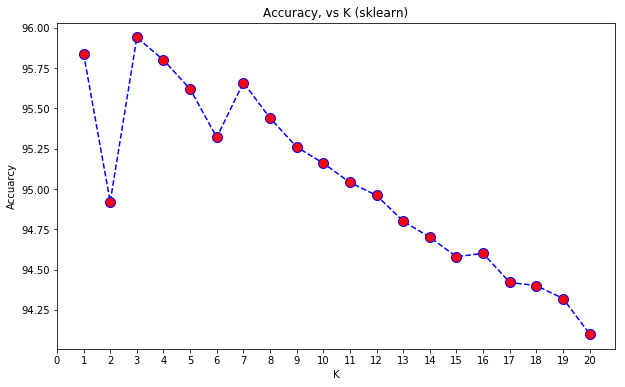

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), accuracy_metrics, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
xint = range(0, k_max+1)
plt.xticks(xint)
plt.title("Accuracy, vs K (sklearn)")
plt.xlabel("K")
plt.ylabel("Accuarcy")

### Mean F1 Score vs K (sklearn)

Text(0,0.5,'Mean F1-Score')

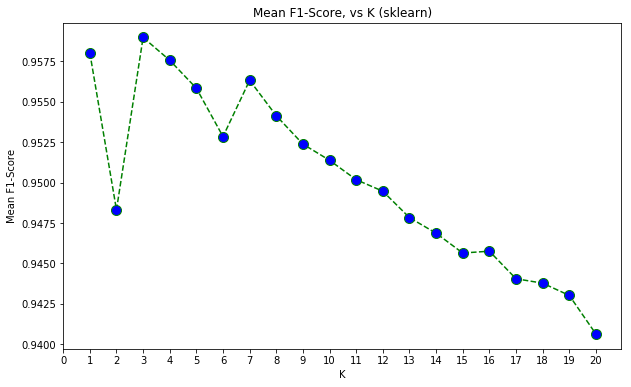

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), f1_scores_mean, color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
xint = range(0, k_max+1)
plt.xticks(xint)
plt.title("Mean F1-Score, vs K (sklearn)")
plt.xlabel("K")
plt.ylabel("Mean F1-Score")

### Observations for best K value (sklearn)

In [26]:
print(f"K Value: {k_best} with best accuracy: {accuracy_metrics[k_best-1]}")
print("====================================================================")
cm = knn_classifier.confusion_matrix(y_validate, results[k_best-1][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
mcm = knn_classifier.multilabel_confusion_matrix(y_validate, results[k_best-1][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
knn_classifier.classification_report(y_validate, results[k_best-1][0], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

K Value: 3 with best accuracy: 95.94
2020-02-01 07:24:43 - INFO - __main__ - Confusion matrix: 
 [[517   0   1   0   0   3   1   0   1   0]
 [  0 557   2   0   1   0   0   1   1   2]
 [  4   4 469   3   1   0   3   6   1   1]
 [  1   3   2 483   0   5   0   1   3   6]
 [  1   5   0   0 439   0   1   0   0  15]
 [  4   2   0  11   2 410   7   0   2   6]
 [  3   2   0   0   1   4 471   0   0   0]
 [  0   6   2   0   0   0   0 489   0   8]
 [  2  10   2  13   6   7   3   1 438   4]
 [  2   0   1   1   5   1   1   5   0 524]]
2020-02-01 07:24:43 - INFO - __main__ - Multilabel confusion matrix: 
 [[[4460   17]
  [   6  517]]

 [[4404   32]
  [   7  557]]

 [[4498   10]
  [  23  469]]

 [[4468   28]
  [  21  483]]

 [[4523   16]
  [  22  439]]

 [[4536   20]
  [  34  410]]

 [[4503   16]
  [  10  471]]

 [[4481   14]
  [  16  489]]

 [[4506    8]
  [  48  438]]

 [[4418   42]
  [  16  524]]]
2020-02-01 07:24:43 - INFO - __main__ - Classification Report: 
               f1-score  precision   

## Final K Value

From the results (custom KNNClassifier, sklearn) the odd K value with highest accuracy is 3.
We use K = 3 to perform prediction on the test data

### Prediction on the test samples

In [33]:
knn_classifier = KNNClassifier()
knn_classifier.train('./Datasets/q1/train.csv')
predictions = knn_classifier.predict('./Datasets/q1/test.csv')
test_labels = list()
with open("./Datasets/q1/test_labels.csv") as f:
  for line in f:
    test_labels.append(int(line))
print(f"Accuracy Score: {accuracy_score(test_labels, predictions)}")

print("Predicted Labels")
print(predictions)
print("Test Labels")
print(test_labels)
print("Accuracy Score")
print(accuracy_score(test_labels, predictions))
print("Confusion Matrix")
cm = knn_classifier.confusion_matrix(test_labels, predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
mcm = knn_classifier.multilabel_confusion_matrix(test_labels, predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cl_report, f1_scores, f1_score_mean, f1_score_stddev, f1_score_median, f1_score_abs_dev = \
knn_classifier.classification_report(test_labels, predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

2020-02-01 07:39:29 - INFO - __main__ - Loading the train data into dataframe
2020-02-01 07:39:33 - INFO - __main__ - Scaling the data
2020-02-01 07:39:58 - INFO - __main__ - Completed Scaling the data
2020-02-01 07:39:58 - INFO - __main__ - Loading the test data into dataframe
2020-02-01 07:39:58 - INFO - __main__ - Scaling the data
2020-02-01 07:40:00 - INFO - __main__ - Completed Scaling the data
2020-02-01 07:40:00 - INFO - __main__ - Computing euclidean distances
Accuracy Score: 0.969
Predicted Labels
[9, 4, 7, 1, 7, 6, 6, 4, 2, 3, 5, 1, 6, 4, 7, 9, 5, 1, 5, 3, 8, 5, 4, 6, 0, 9, 6, 5, 2, 7, 8, 6, 6, 5, 6, 6, 5, 7, 9, 3, 9, 0, 7, 6, 7, 5, 1, 9, 1, 1, 7, 7, 9, 1, 4, 9, 0, 3, 2, 9, 6, 7, 9, 6, 4, 3, 9, 6, 9, 2, 0, 4, 7, 2, 2, 4, 6, 0, 1, 9, 2, 3, 2, 4, 2, 0, 3, 5, 6, 1, 2, 3, 9, 6, 0, 5, 2, 8, 4, 2, 8, 5, 2, 7, 8, 2, 9, 2, 1, 7, 6, 0, 3, 0, 4, 5, 0, 2, 3, 5, 2, 0, 6, 2, 9, 7, 9, 9, 1, 9, 7, 0, 4, 8, 2, 9, 1, 2, 3, 0, 3, 3, 9, 3, 0, 0, 8, 3, 3, 9, 8, 9, 5, 7, 5, 4, 9, 2, 7, 6, 9, 6, 0

2020-02-01 07:42:01 - INFO - __main__ - Mean F1-Score ± Std Deviation: 0.9690533807712107 ± 0.01594339181826993
2020-02-01 07:42:01 - INFO - __main__ - Median F1-Score ±  Median absolute deviation: 0.976238795873499 ± 0.013682422701296248
